# Detecting direction of motion of object in videos

This notebook covers using Microsoft CNTK to detect direction of motion of an object in a video. We will use a CNN for this purpose.Please read through CNTK_103D tutuorial to understand the basics of building a CNN using CNTK. 
The dataset used is synthetically generated. Please see gen-video-dataset-with-motion.ipynb for how the data is generated

In [1]:
from IPython.display import display, Image
from datetime import datetime

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import subprocess as sp

from cntk.io import UserMinibatchSource, StreamInformation, MinibatchData, Value

%matplotlib inline

# Ensure we always get the same amount of randomness
np.random.seed(0)

### Global variables

Define the global variables

In [14]:
# Define the data dimensions
global frameWidth
global frameHeight
global numFrames
global numChannels

global input_dim_model 
global input_dim
global num_output_classes

global cx 
global cy 
global cz

global plotdata

plotdata = {"minibatch_num":[], "loss":[], "error":[], "time":[]}

FFMPEG_BIN = "c:\\vsprojects\\ffmpeg\\ffmpeg.exe"

### Helper function to initialize global variables

A helper function to initialize the global variables

In [11]:
def initializeVariables(channels, outputs, width, height, depth):
    global frameWidth, frameHeight, numFrames, numChannels, input_dim_model, input_dim, num_output_classes, cx, cy, plotdata

    
    frameWidth = width
    frameHeight = height
    numFrames = depth
    numChannels = channels
    
    input_dim_model = (channels, width, height, depth)
    
    input_dim = channels * width * height * depth
    num_output_classes = outputs
    
    cx = C.input_variable(input_dim_model)
    cy = C.input_variable(num_output_classes)
    

### Helper function to read frames from a video

This helper function reads frames from a video and returns it as a numpy array

In [4]:
def readFramesFromVideo(videoFileName, numFrames, numChannels, frameWidth, frameHeight):
    
    command = [FFMPEG_BIN,
            '-i', videoFileName,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
    
    pipe = sp.Popen(command, stdout = sp.PIPE, bufsize = numChannels * frameWidth * frameHeight * 8)    
    
    video = np.array([])
    for i in range(0, numFrames):
                
        # read numChannels * frameWidth * frameHeight bytes (= 1 frame)        
        raw_image = pipe.stdout.read(numChannels * frameWidth * frameHeight)
    
        # transform the byte read into a numpy array
        # Note that the data will come back organized as height x width x channel
        #image =  np.fromstring(raw_image, dtype='uint8')
        image =  np.frombuffer(raw_image, dtype='uint8')
        
        video = np.concatenate((video, image), axis = 0)            
    
        # throw away the data in the pipe's buffer.
        pipe.stdout.flush()
        
    pipe.kill()
    
    # reshape the numpy array as it is currently a 1 dimensional array
    video = video.reshape((numFrames, frameHeight, frameWidth, numChannels))
    

    # transpose the array to organize the data by channel x width x height x numFrames
    video = video.transpose(3, 2, 1, 0)       
    
    return video
    
       

In [5]:
v = readFramesFromVideo("./train-rgb-motion-dataset/0.mp4", 1, 3, 600, 600)
print(v.shape)

(3, 600, 600, 1)


### A class for reading videos in batches

This is not covered in the CNTK CNN tutorial. Here we define a class that inherits from "UserMinibatchSource". The purpose of this class is to serve as the source of data for videos (and the corresponding labels) read in batches. This class builds upon what was covered for reading images in batches in 2D_CNN.ipynb. Read through https://cntk.ai/pythondocs/Manual_How_to_create_user_minibatch_sources.html to understand more about writing classes derived from UserMinibatchSource

In [6]:
class VideoDataSource(UserMinibatchSource):
    def __init__(self, idx_filename, width, height, depth, channels, numLabels):
        
        self.width = width
        self.height = height
        self.depth = depth
        self.channels = channels
        self.numLabels = numLabels                
        
        self.featureDimensions = channels * width * height * depth
        
        self.fsi = StreamInformation("features", 0, 'dense', np.float32, (self.featureDimensions,))
        self.lsi = StreamInformation("labels", 1, 'dense', np.float32, (self.numLabels,))
        
        self.data = {}
        self.datafiles = []
        
        if not os.path.isfile(idx_filename):
            print("Index file " + idx_filename + " not found")
            return
        else:
            # Read the index file
            
            f = open(idx_filename, "r")
            
            lines = f.readlines()
            for x in lines:
                x = x.strip()
                videoFile, videoLabel = x.split('\t', 1)
                
                self.datafiles.append([videoFile, int(videoLabel)])
            f.close()
            
        self.next_seq_idx = 0
        
        # Create a matrix to represent the one-hot labels corresponding to the outputs
        self.label_onehot = np.eye(numLabels, dtype=int)
        
        super(VideoDataSource, self).__init__()

    def stream_infos(self):
        return [self.fsi, self.lsi]
    
    def get_checkpoint_state(self):
        return {'next_seq_idx': self.next_seq_idx}
    
    def restore_from_checkpoint(self, state):
        self.next_seq_idx = state['next_seq_idx']

    def next_minibatch(self, num_samples, number_of_workers=1, worker_rank=0, device=None):
        # Note that in this example we do not yet make use of number_of_workers or
        # worker_rank, which will limit the minibatch source to single GPU / single node
        # scenarios.

        features = []
        labels = []

        sweep_end = False

        sample_count = 0
        
        while (sample_count < num_samples):
            if self.next_seq_idx == len(self.datafiles):
                sweep_end = True
                self.next_seq_idx = 0
            
            video = readFramesFromVideo(self.datafiles[self.next_seq_idx][0], self.depth, 
                                        self.channels, self.width, self.height)
                        
                        
            #Assign the one-hot encoded label to l_data
            l_data = self.label_onehot[self.datafiles[self.next_seq_idx][1]]
            
            features.append(video)
            labels.append(l_data)
                        
            sample_count = sample_count + 1
            self.next_seq_idx = self.next_seq_idx + 1
            
        num_seq = len(features)
                               
        f_data = Value(batch=np.asarray(features, dtype=np.float32))
        l_data = Value(batch=np.asarray(labels, dtype=np.float32))    
        
        result = {            
                cx: MinibatchData(f_data, num_seq, sample_count, sweep_end),
                cy: MinibatchData(l_data, num_seq, sample_count, sweep_end)
                }
   

        return result      

    def print_checkpointState():
        print("next_seq_idx=" + str(self.next_seq_idx))

### Test VideoDataSource class

Lets test the class above to make sure we are getting data in the right format

In [7]:
initializeVariables(1, 8, 300, 300, 2)
v = VideoDataSource("./test-mono-motion.txt", 300, 300, 2, 1, 8)
r = v.next_minibatch(1)
print(r)

{Input('Input3', [#], [1 x 300 x 300 x 2]): MinibatchData(data=Value([1 x 1 x 300 x 300 x 2], CPU), samples=1, seqs=1), Input('Input4', [#], [8]): MinibatchData(data=Value([1 x 8], CPU), samples=1, seqs=1)}


### Function to build the 3D CNN model

The function below builds a 3D CNN model. To understand this, first read CNTK_103D tutorial, which explains how to build a 2D CNN model.


In [8]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features

            h = C.layers.Convolution3D(filter_shape=(5,5,5), 
                                       num_filters=4, 
                                       strides=(3,3,3), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2,2), 
                                    strides=(2,2,2), name="first_max")(h)               
            h = C.layers.Convolution3D(filter_shape=(5,5,5), 
                                       num_filters=4, 
                                       strides=(3,3,3), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2,2), 
                                    strides=(2,2,2), name="second_max")(h)        
            
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)

            return r

### More helper functions
The functions below are copied from CNTK_103D tutorial (read that tutorial for a better understanding of what they do)

In [9]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

In [10]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, start_time, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    time_since_start = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        time_since_start = "{:.1f}".format(time.time() - start_time)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100) + 
                   ", Time since start: " + time_since_start)
        
    return mb, training_loss, eval_error, time_since_start

### Function to train CNN based on provided training dataset
The function below goes through the cycle of training the CNN. There is mechanism to create a checkpoint for every minibatch. Read through https://cntk.ai/pythondocs/Manual_How_to_train_using_declarative_and_imperative_API.html to learn more about creating checkpoints to avoid restarting training from scratch in the event of an unexpected failure

In [11]:
def video_train(train_reader, model_func, logFile, checkpointFile, 
                train_minibatch_size = 30, num_samples_per_sweep = 40000, 
                num_sweeps_to_train_with = 10, learning_rate = 0.1, training_progress_output_freq = 1):
    
    global plotdata
    
    print("Training minibatch size = " + str(train_minibatch_size))
    print("Number of samples per sweep = " + str(num_samples_per_sweep))
    print("Number of sweeps to train with = " + str(num_sweeps_to_train_with))
    print("Learning rate = " + str(learning_rate))
    print("Number of frames per video = " + str(numFrames))
    
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(cx/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, cy)
    
    # Instantiate the trainer object to drive the model training
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(cz.parameters, lr_schedule)
    trainer = C.Trainer(cz, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / train_minibatch_size
           
    # Start a timer
    start = time.time()
    
    print("Number of mini batches to train = " + str(num_minibatches_to_train))
    
    fLogFile = open(logFile, "a+")

    if os.path.exists(checkpointFile):
        print("Trying to restore from checkpoint")
        #print(train_reader.next_seq_idx)
        
        mb_source_state = trainer.restore_from_checkpoint(checkpointFile)  
        train_reader.restore_from_checkpoint(mb_source_state)

        print("Restore has finished successfully")
        #print(train_reader.next_seq_idx)
    
    else:
        print("No restore file found")    
    
    train = True
    iteration_num = int(trainer.total_number_of_samples_seen / train_minibatch_size)
    while (train and (iteration_num < num_minibatches_to_train)):
    #for i in range(0, int(num_minibatches_to_train)):
            
        # Read a mini batch from the training dataset
        data=train_reader.next_minibatch(train_minibatch_size)
        
        train = trainer.train_minibatch(data)
        mb, training_loss, eval_error, time_since_start = print_training_progress(trainer, iteration_num, 
                                                                                  training_progress_output_freq, start, 
                                                                                  verbose=0)
        
        mb_source_state = train_reader.get_checkpoint_state()
        trainer.save_checkpoint(checkpointFile, mb_source_state)
        
        
        if ((iteration_num % training_progress_output_freq) == 0):            
            logLine = "{0}\t{1:.4f}\t{2:.2f}%\t{3}\t{4}\n".format(mb, training_loss, eval_error*100, time_since_start,
                                                                 datetime.now().strftime('%H:%M:%S'))
            fLogFile.write(logLine)      
            fLogFile.flush()                  
     
        iteration_num = int(trainer.total_number_of_samples_seen / train_minibatch_size)
        
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    fLogFile.close()
    
    return trainer

### Function to test the trained CNN
The function below goes through the cycle of testing the CNN

In [12]:
def video_test(trainer, test_reader, num_test_samples = 8000, test_minibatch_size = 50, print_frequency = 500):
    
    # Test data for trained model       
    num_minibatches_to_test = num_test_samples // test_minibatch_size

    print("Number of minibatches to test = " + str(num_minibatches_to_test))
    test_result = 0.0   

    for i in range(0, num_minibatches_to_test):               
        # We are loading test data in batches specified by test_minibatch_size
        data = test_reader.next_minibatch(test_minibatch_size)
            
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error
        
        if ((i % print_frequency) == 0):
            print("Testing minibatch " + str(i) + " Eval error = " + str(eval_error))

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result * 100 / num_minibatches_to_test))   

Helper function to create readers and trigger training and testing

In [13]:
def train_and_test(train_file, trainLogFile, test_file, modelFile, train_minibatch_size = 30, num_samples_per_sweep = 40000, 
                   num_sweeps_to_train_with = 2, learning_rate = 0.2):
    global cz
    
    cz = create_model(cx)
    reader_train = VideoDataSource(train_file, frameWidth, frameHeight, numFrames, numChannels, num_output_classes)    
    reader_test = VideoDataSource(test_file, frameWidth, frameHeight, numFrames, numChannels, num_output_classes)
    
    trainer = video_train(reader_train, cz, trainLogFile, modelFile, train_minibatch_size, 
                          num_samples_per_sweep, num_sweeps_to_train_with, learning_rate)
    video_test(trainer, reader_test)     

### Plot charts
Function to plot the charts to showcase progress during training

In [21]:
def plotCharts():

    plt.figure(1)
    plt.subplot(211)
    plt.plot(plotdata["minibatch_num"], plotdata["loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss')

    plt.show()

    plt.subplot(212)
    plt.plot(plotdata["minibatch_num"], plotdata["error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error')
    plt.show()

### Train model for black and white videos
Finally, use all the functions above to initialize variables, create the model and start the training and testing cycle

In [15]:
initializeVariables(1, 8, 300, 300, 90)

trainIdx = "./train-mono-motion.txt"
testIdx = "./test-mono-motion.txt"
trainLogFile = "./train-mono-motion-log.txt"
checkpointFile = "./chk-mono-8motions-video.dnn"
modelFile = "./mono-8motions-video.dnn"

# Create the model
cz = create_model(cx)

# Number of parameters in the network
C.logging.log_number_of_parameters(cz)

train_and_test(trainIdx, trainLogFile, testIdx, checkpointFile)

if os.path.isfile(modelFile):
    os.remove(modelFile)

# Save the model to a file
cz.save(modelFile)

#plotCharts()

Training 6612 parameters in 6 parameter tensors.
Training minibatch size = 30
Number of samples per sweep = 40000
Number of sweeps to train with = 2
Learning rate = 0.2
Number of frames per video = 90
Number of mini batches to train = 2666.6666666666665
Trying to restore from checkpoint
Restore has finished successfully
Training took 140292.3 sec
Number of minibatches to test = 160
Testing minibatch 0 Eval error = 0.06
Average test error: 5.86%


## Results

Running two iteration on the data gave pretty good results. The error is low with the test data set and is most inline with the error observed with the training data set.

You can experiment with changing the network parameters to see what happens. One thing to keep in mind - Keep the number of parameters low. 

### Function to plot charts of loss and error from the data logged in the logfile

In [30]:
def plotChartsFromLogFile(logFileName):
    
    global plotdata

    f = open(logFileName, "r")

    lines = f.readlines()
    i = 0
    j = 0
    
    for x in lines:
        if ((i % 100) == 0):
            x = x.strip()
            minibatch_num, loss, error, time_since_start, abs_time = x.split('\t', 4)
            plotdata["minibatch_num"].append(j)
            plotdata["loss"].append(float(loss))
            plotdata["error"].append(float(error.strip('%')))
            j = j + 1
            
        i = i + 1

        
    f.close()
    
    plotCharts()

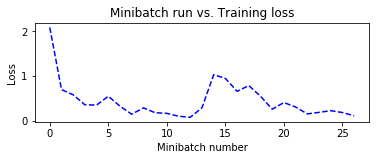

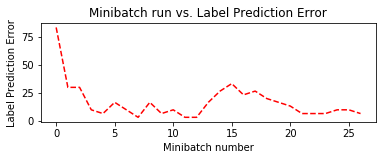

In [31]:
plotdata = {"minibatch_num":[], "loss":[], "error":[], "time":[]}
plotChartsFromLogFile("./train-mono-motion-log.txt")